# Visualizing Dota 2 Teams Performance

In [1]:
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

The data had been fetched from OpenDota API and preprocessed to get a dataframe consisting of the results of the active teams for patch 7.26c.

In [2]:
pro_results = pd.read_pickle('data\pro_teams_results.pkl')

Team names and over all results were not included in the preprocessed data so let's get these data from OpenDota API and merge it to our current dataframe.

In [ ]:
teams = pd.DataFrame([])
for team in pro_results['team']:
    r = requests.get('https://api.opendota.com/api/teams/{}'.format(int(team)))
    print(r)
    teams = teams.append(pd.read_json(r.text, lines=True, orient='columns'))
    print('Getting data for team {}.'.format(team), flush=True)
    time.sleep(1)
results = pro_results.merge(teams, how='left', left_on='team', right_on='team_id')


In [3]:
# results.to_pickle('data\pro_results_expanded.pkl')
results = pd.read_pickle('data\pro_results_expanded.pkl')

In [4]:
# Add more columns to the dataframe and filter to get only the teams that played more than 30 matches
results['patch_wins'] = results['radiant_wins'] + results['dire_win']
results['patch_win_rate'] = results['patch_wins']/results['matches']
results['win_rate'] = results['wins']/(results['wins'] + results['losses'])
results['dire_win_rate'] = results['dire_win']/(results['dire_win']+results['dire_losses'])
results['radiant_win_rate'] = results['radiant_wins']/(results['radiant_wins']+results['radiant_losses'])
results = results[results['matches'] > 30]

In [5]:
patch_wins = results['patch_wins'].to_numpy().reshape((-1,1))
patch_wins = np.log(patch_wins)

log_lin_reg = LinearRegression()

log_lin_reg.fit(patch_wins, (results['patch_win_rate']*100).to_numpy())
curve_fit = log_lin_reg.predict(patch_wins)

In [6]:
annotate_teams = results.nlargest(n=3, columns='patch_win_rate', keep='first')
annotate_teams = annotate_teams.append(results.nlargest(n=1, columns='patch_wins', keep='first'))

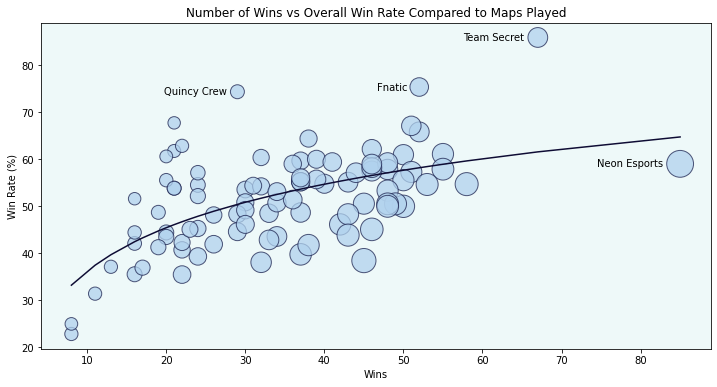

In [7]:
fig, ax = plt.subplots(figsize=(12,6))

plt.title("Number of Wins vs Overall Win Rate Compared to Maps Played")
ax.set_facecolor('#eef9f9')

ax.scatter(x=results['patch_wins'],
           y=results['patch_win_rate']*100,
           s=results['matches']*5,
           c='#b1d2ee',
           edgecolors='#1a214e',
           alpha=0.75)
ax.plot(results['patch_wins'].sort_values(), np.sort(curve_fit),
        c='#0e0c34')

# Can't automate these annotations yet
ax.annotate(annotate_teams['name'].iloc[0],
            xy=(annotate_teams['patch_wins'].iloc[0], annotate_teams['patch_win_rate'].iloc[0]*100),
            xytext=(-75, -3),
            xycoords=('data', 'data'),
            textcoords='offset points',
            fontsize=10)
ax.annotate(annotate_teams['name'].iloc[1],
            xy=(annotate_teams['patch_wins'].iloc[1], annotate_teams['patch_win_rate'].iloc[1]*100),
            xytext=(-42, -3),
            xycoords=('data', 'data'),
            textcoords='offset points',
            fontsize=10)
ax.annotate(annotate_teams['name'].iloc[2],
            xy=(annotate_teams['patch_wins'].iloc[2], annotate_teams['patch_win_rate'].iloc[2]*100),
            xytext=(-73, -3),
            xycoords=('data', 'data'),
            textcoords='offset points',
            fontsize=10)
ax.annotate(annotate_teams['name'].iloc[3],
            xy=(annotate_teams['patch_wins'].iloc[3], annotate_teams['patch_win_rate'].iloc[3]*100),
            xytext=(-83, -3),
            xycoords=('data', 'data'),
            textcoords='offset points',
            fontsize=10)
ax.set_xlabel('Wins')
ax.set_ylabel('Win Rate (%)')
fig.savefig('data\wins_vs_winrate.png')

In [8]:
results['dire_win_rate'] = results['dire_win']/(results['dire_win']+results['dire_losses'])
results['radiant_win_rate'] = results['radiant_wins']/(results['radiant_wins']+results['radiant_losses'])

radiant_win_rate = (results['radiant_win_rate']*100).to_numpy().reshape((-1,1))
dire_win_rate = (results['dire_win_rate']*100).to_numpy()

lin_reg = LinearRegression()

lin_reg.fit(radiant_win_rate, dire_win_rate)
curve_fit = lin_reg.predict(np.linspace(0,100).reshape((-1,1)))

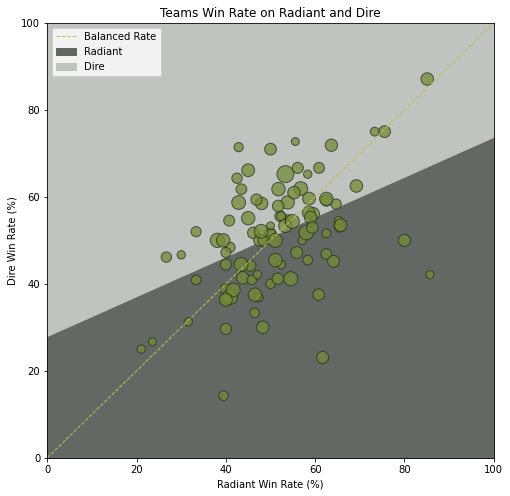

In [10]:
fig, ax = plt.subplots(figsize=(8,8))

plt.title("Teams Win Rate on Radiant and Dire")
ax.set_facecolor('#758b37')

ax.plot(np.linspace(0,100), np.linspace(0,100),
        c='#c1bd58',
        linewidth=1,
        linestyle='--',
        label='Balanced Rate')
ax.fill_between(np.linspace(0,100), curve_fit, color='#646864', label='Radiant')
ax.fill_between(np.linspace(0,100), 100, curve_fit, color='#c0c3c0', label='Dire')
ax.scatter(x=results['dire_win_rate']*100,
           y=results['radiant_win_rate']*100,
           s=results['matches']*2,
           c='#758b37',
           edgecolors='#292f1e',
           alpha=0.75)
ax.set_xbound(0,100)
ax.set_ybound(0,100)
ax.set_xlabel('Radiant Win Rate (%)')
ax.set_ylabel('Dire Win Rate (%)')

ax.legend()

fig.savefig('data\dire_radiant.png')

In [11]:
results['heroes_played_per_match'] = results['unique_heroes_played']/results['matches']
results['heroes_banned_per_match'] = results['unique_heroes_banned_against']/results['matches']

heroes_played_per_match = results['heroes_played_per_match'].to_numpy()
heroes_banned_per_match = results['heroes_banned_per_match'].to_numpy()
wins = results['patch_wins'].to_numpy().reshape((-1,1))

lin_reg = LinearRegression()

poly_reg = PolynomialFeatures(degree=3)
wins_poly = poly_reg.fit_transform(wins)

lin_reg.fit(wins_poly, heroes_played_per_match)
curve_fit_played = lin_reg.predict(poly_reg.transform(np.linspace(0,100).reshape((-1,1))))

lin_reg.fit(wins_poly, heroes_banned_per_match)
curve_fit_banned = lin_reg.predict(poly_reg.transform(np.linspace(0,100).reshape((-1,1))))

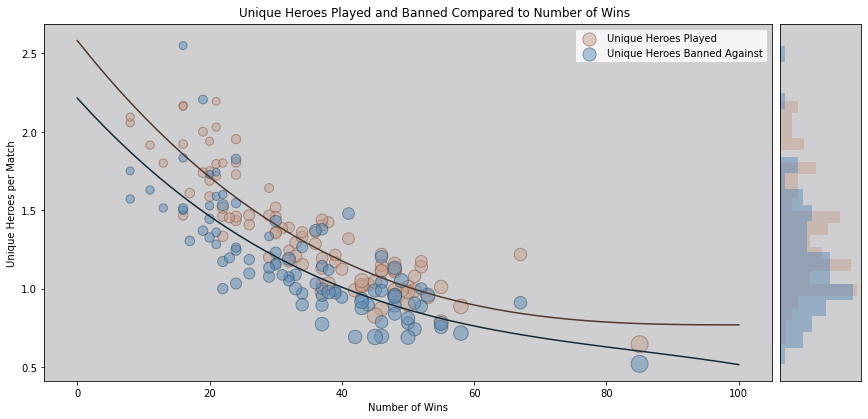

In [12]:
fig, (ax, ax_hist)= plt.subplots(1, 2, figsize=(12,6), sharey=True, gridspec_kw={'width_ratios': [9, 1]})

fig.suptitle("Unique Heroes Played and Banned Compared to Number of Wins")
ax.set_facecolor('#CFCFD2')

ax.scatter(x=results['patch_wins'],
           y=results['heroes_played_per_match'],
           s=results['matches']*2,
           c='#C5A191',
           edgecolors='#86513A',
           alpha=0.50,
           label='Unique Heroes Played')
ax.scatter(x=results['patch_wins'],
           y=results['heroes_banned_per_match'],
           s=results['matches']*2,
           c='#608CB7',
           edgecolors='#2B4A65',
           alpha=0.50,
           label='Unique Heroes Banned Against')
ax.plot(np.linspace(0,100), curve_fit_played, c='#4F382F')
ax.plot(np.linspace(0,100), curve_fit_banned, c='#142834')

ax.set_xlabel('Number of Wins')
ax.set_ylabel('Unique Heroes per Match')
ax.legend()

ax_hist.set_facecolor('#CFCFD2')
ax_hist.hist(results['heroes_played_per_match'], 
             bins=20, 
             density=True, 
             orientation='horizontal',
             alpha=0.5,
             color='#C5A191')
ax_hist.hist(results['heroes_banned_per_match'], 
             bins=20, 
             density=True, 
             orientation='horizontal',
             alpha=0.5,
             color='#608CB7',)
ax_hist.axes.xaxis.set_visible(False)
ax_hist.axes.yaxis.set_visible(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95], pad=0.5)

fig.savefig('data\heroes_played_banned.png')

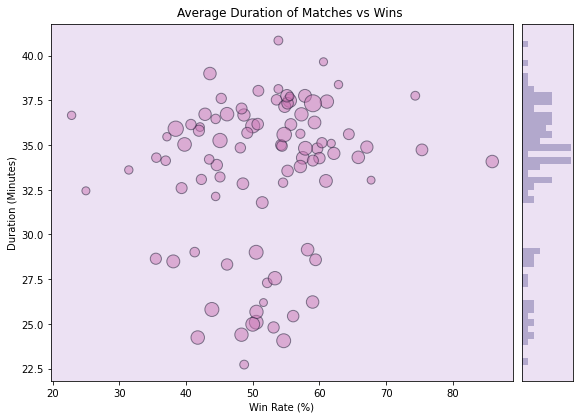

In [13]:
fig, (ax, ax_hist)= plt.subplots(1, 2, figsize=(8,6), sharey=True, gridspec_kw={'width_ratios': [9, 1]})

fig.suptitle("Average Duration of Matches vs Wins")
ax.set_facecolor('#ECE1F3')

ax.scatter(x=results['patch_win_rate']*100,
           y=results['duration']/60,
           s=results['matches']*2,         
           c='#CA76B4',
           edgecolors='#15172D',
           alpha=0.50,
           label='Unique Heroes Played')
ax.set_xlabel('Win Rate (%)')
ax.set_ylabel('Duration (Minutes)')
ax_hist.set_facecolor('#ECE1F3')
ax_hist.hist(results['duration']/60, 
             bins=50, 
             density=True, 
             orientation='horizontal',
             alpha=0.5,
             color='#7A70A6')
ax_hist.axes.xaxis.set_visible(False)
ax_hist.axes.yaxis.set_visible(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95], pad=0.5)

fig.savefig('data\duration.png')